In [1]:
using Distributions
using Random
using Plots
using PyPlot
using StatsBase

# New Updates

By "New Updates", we mean a way of updating in which all states in a "chain" of actions recieve the same update. For example, if in state s action a1 is taken, then in state s+a1 action a2 is taken, and then in state s + a1 + a2 no action is taken, then the update rule performed for s+a1+a2 is also "fed back" and done for s and s+a1, replacing the previous approach which simply used updates of V(s+a1) for s, and V(s+a1+a2) for s+a1. 

Additionally, update targets c + E{V(s')} - V(s0) or c + E{V(s')} - gt have been replaced by c + E{V(s')} - V(s0) - gt in the Cont-AVI algorithms; this seems to lead to better VFAs. This is done in both the old ContFull algorithm, and in our new algorithm. ContApprox has been deprecated, as it doesn't make sense to approximate E{V(s')} when we need to calculate it for the passive action anyway. However, APE-FA-ContApprox remains in use, as this doesn't require the calculation of expected values to find actions.

We also introduce gEvaluationContFixed, which takes a parameter g0 which replaces g in the action selection, so that the same policy is used throughout.

Some investigation in Exact DP reveals that, in some situations, the value function can in fact become negative. Such a situation can be constructed as follows: consider the 5 link inhomogeneous problem. Create a policy which is fully passive when link 3 is healthy, and is close to optimal (or at least reasonable) when 3 is damaged, and never repairs 3. Starting in state s0 = (1,1,1,1,1) then means we have to "suffer through" the use of a bad policy until link 3 becomes broken, past which we never repair 3 and use a much better policy. State (1,1,3,1,1) therefore becomes better than s0, and therefore recieves a negative value function when s0 is the reference state.

Due to this investigation, the rule in the AVI/APE functions which ensured update targets vHat became max(vHat,0) has been removed.

# AVI-Suite

AVI-Suite provides the necessary functions for uniformised AVI, continuous time AVI, evaluation via simulation, and exact evaluation via DP, all in one place. This provides a flexible testbed for testing all four of the AVI algorithms, and ensures that all functions are named such that their purpose is clear, and there is no confusion between similar functions.

Sections:

-[Miscellaneous Functions](#Miscellaneous-Functions)

-[Pre-requisite functions for uniformised AVI](#Pre-requisite-functions-for-uniformised-AVI)

-[Uniformised AVI functions](#Uniformised-AVI-functions)

-[Pre-requisite functions for continuous time AVI](#Pre-requisite-functions-for-continuous-time-AVI)

-[Continuous time AVI Functions](#Continuous-time-AVI-Functions)

-[Pre-requisite Functions for Exact DP on Homogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Homogeneous-Problems)

-[Exact DP on Homogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Homogeneous-problem)

-[Pre-requisite Functions for Exact DP on Inhomogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Inhomogeneous-Problems)

-[Exact DP on Inhomogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Inhomogeneous-Problem-(using-exact-h-or-VFA))

-[Evaluation via simulation](#Evaluation-via-simulation)

-[APE on Fully Active Policy](#APE-on-Fully-Active-Policy)

-[APE using a given VFA](#APE-using-a-given-VFA)

# Miscellaneous Functions

-Functions for enumerating state and action spaces

-Functions for calculating flows given a state or state-action pair

-Function for evaluating a VFA at a given state

In [2]:
#produce an array of array representations of all possible states
function enumerateStates(N::Int64)
    if N==1
        return [[1],[2],[3]]
    end
    
    output = []
    lower = enumerateStates(N-1)
    for s in lower
        new1 = append!([1],s)
        new2 = append!([2],s)
        new3 = append!([3],s)
        append!(output,[new1])
        append!(output,[new2])
        append!(output,[new3])
    end
    
    return output
end

#produce an array of array representations of all possible actions
function enumerateActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = []
    lower = enumerateActions(N-1)
    for a in lower
        new1 = append!([0],a)
        new2 = append!([1],a)
        append!(output,[new1])
        append!(output,[new2])
    end
    
    return output
end    

#produce array of array representations of all restricted, or single-repair, actions
function enumerateRestrictedActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = [zeros(Int64,N)]
    for i in 1:N
        temp = zeros(N)
        temp[i] = 1
        append!(output,[temp])
    end
    
    return output
end

#convert all array elements to string, then concatanate all elements (DEPRECATED AS DICTS CAN TAKE ARRAYS AS KEYS)
function arrayToString(x)
    return join(string.(x))
end

arrayToString (generic function with 1 method)

In [3]:
#function for calculating the flows given a state
function calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    #update flows
    flows = zeros(N)
    healthy = sum(i == 1 for i in s)
    
    #if no links are healthy, return 
    if healthy == 0
        return flows, c1
    end
    
    #otherwise, find best route, and return
    bestCost = maximum(c0) + 1
    usedLink = 0
    for k in 1:N
        if s[k] == 1 && c0[k] < bestCost
            bestCost = c0[k]
            usedLink = k
        end
    end
    
    flows[usedLink] = beta
    
    return flows, bestCost
end

#function for calculating the flows given a state-action pair
function calculateFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    sPrime = s - a
    return calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
end

calculateFlows (generic function with 2 methods)

In [4]:
#evaluate a VFA at a given state
function v(s, params, features)
    numFeatures = length(features)
    return params[1] + sum(params[i+1]*features[i](s) for i in 1:numFeatures)
end

v (generic function with 1 method)

# Pre-requisite functions for uniformised AVI

In [5]:
#Given a state-action pair, return the next random pre-decision state, the instant cost, and the updated flows
function updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #observe exogenous information
    w = rand(Uniform(0, 1))
    
    #interpret exog info: is it a demand deg, rare deg, or completed repair 
    found = false
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        if runningTotal <= w <= runningTotal + flows[k]*alpha_d[k]*del
            found = true
            sPrime[k] = 3
            #println("Demand Deg at "*string.(k))
            break
        end
        runningTotal = runningTotal + flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + alpha_r[k]*del
                found = true
                sPrime[k] = 3
                #println("Rare Deg at "*string.(k))
                break
            end
            runningTotal = runningTotal + alpha_r[k]*del
        end
    end
    
    #repairs
    if found == false && repair > 0
        if runningTotal <= w <= runningTotal + tau(repair)*del
            found = true
            #find all repairing links
            repairing = []
            for k in 1:N
                if sPrime[k] == 2
                    append!(repairing,[k])
                end
            end
            repaired = sample(repairing)
            sPrime[repaired] = 1
            #println("Repair completed at "*string.(repaired))
        end
    end
    
    if found == false
        #println("No Event")
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    healthy = sum(i == 1 for i in sPrime)
    
    return sPrime, (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del, newFlows
end

updateStateAndFlowsUnif (generic function with 1 method)

In [6]:
#instant cost over the timestep
function instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    sPrime = s - a
    healthy = sum(sPrime[i] == 1 for i in 1:N)
    repair = sum(sPrime[i] == 2 for i in 1:N)
    damaged = sum(sPrime[i] == 3 for i in 1:N)
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del
end

instantCostUnif (generic function with 1 method)

In [7]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h. Also used in Exact PE/PI when using a VFA
#One version takes flows as an argument, the other calculates the flows
function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    flows = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

expectedNextValueUnif (generic function with 2 methods)

# Uniformised AVI functions

In [78]:
#Performs AVI in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function approxValueIterationUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationUnifApprox (generic function with 1 method)

In [79]:
#Performs AVI in uniformised setting, approximating E(h(s')) using all possible transitions
function approxValueIterationUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationUnifFull (generic function with 1 method)

# Pre-requisite functions for continuous time AVI

In [10]:
#Calculate the expected sojourn time of a state-action pair
function sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    s = s - a
    if s == fill(3,N)
        return 1/(beta*sum(alpha_d) + sum(alpha_r) + tau(N))
    end
    
    numRep = sum(i == 2 for i in s)
    cumulativeRate = 0.0
    for i in 1:N
        if s[i] == 1
            cumulativeRate += flows[i]*alpha_d[i] + alpha_r[i]
        elseif s[i] == 2
            cumulativeRate += alpha_r[i] + tau(numRep)/numRep
        end
    end
    
    return 1/cumulativeRate
end

sojournTime (generic function with 1 method)

In [11]:
#calculate the expected cost accumulated until a transition 
function instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = 0)
    if del == 0
        del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    end
    
    return instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
end

instantCostCont (generic function with 1 method)

In [12]:
#Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows
function updateStateAndFlowsCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    actualTime = rand(Exponential(del))
    result = updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    return result[1], instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = actualTime), result[3], actualTime
end

updateStateAndFlowsCont (generic function with 1 method)

In [13]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h
function expectedNextValueCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,vParams,features)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueCont (generic function with 1 method)

# Continuous time AVI Functions

In [76]:
#Performs AVI in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
#DEPRECATED!
function approxValueIterationContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA = zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features) 
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        bestV = max(bestV, 0)
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationContApprox (generic function with 1 method)

In [77]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
function approxValueIterationContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationContFull (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Homogeneous Problems 

In [16]:
#instant cost function strictly for homogeneous problem
function instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    
    #if no links are healthy, return 
    if N - i1 - i2 == 0
        return (beta*c1 + r*i2Prime)*del
    end
    
    
    return (beta*c0 + r*i2Prime)*del
end

instantCostHomog (generic function with 1 method)

In [17]:
#calculates E(h(s')) from s,a strictly for a homogeneous problem
function expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    thisH = h[i1+1,i2+1]
    
    #if all are damaged
    if i1Prime == N
        return thisH
    end
    
    #if none are healthy
    if N - i1 - i2 == 0
        return thisH + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH) + i2Prime*del*alpha_r*(h[i1Prime+1+1, i2Prime-1+1] - thisH)
    end
    
    #if none are repairing
    if i2Prime == 0
        return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH)
    end
    
    return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH) + i2Prime*alpha_r*del*(h[i1Prime+1+1,i2Prime-1+1] - thisH) + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH)
end

expectedNextValueHomog (generic function with 1 method)

In [18]:
#calculates the exact PI action strictly for a homogeneous problem
function piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        for a in 2:i1
            testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for a in 1:i1
        testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomog (generic function with 1 method)

In [19]:
#calculates the approx PI action based on instantaneous approximation, strictly for a homogeneous problem
function piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = h[i1-optA+1,i2+optA+1]
        for a in 2:i1
            testH = h[i1-a+1,i2+a+1]
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) - g*del
    for a in 1:i1
        testH = h[i1-a+1,i2+a+1]
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomogApprox (generic function with 1 method)

In [20]:
#calculates the exact PI policy strictly for a homogeneous problem
function piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomog (generic function with 1 method)

In [21]:
#calculates the approx PI policy based on instantaneous approximation, strictly for a homogeneous problem
function piPolicyHomogApprox(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomogApprox (generic function with 1 method)

In [22]:
function hFromVFAHomog(N, params, features)
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    return hIn
end

hFromVFAHomog (generic function with 1 method)

# Exact DP for Homogeneous problem

In [23]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rpiHomog(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomog(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomog (generic function with 1 method)

In [24]:
#Evaluates the fully active policy, strictly for a homogeneous problem 
function rpeFAHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = i1
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rpeFAHomog (generic function with 1 method)

In [25]:
#Evaluates an approximate PI policy based on a given exact h function and instananeous actions, strictly for a homogeneous problem 
function rpiHomogApprox(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomogApprox(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomogApprox (generic function with 1 method)

In [26]:
#Evaluates a PI policy based on a given VFA, using instananeous approximation, strictly for a homogeneous problem 
function rpiHomogVFAApprox(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomogApprox(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFAApprox (generic function with 1 method)

In [27]:
#Evaluates a PI policy based on a given VFA, strictly for a homogeneous problem 
function rpiHomogVFA(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomog(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFA (generic function with 1 method)

In [28]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rviHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rviHomog (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Inhomogeneous Problems

In [29]:
#calculates E(h(s')) from s,a using exact h table
function expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    
    flows = zeros(Float64, N)
    if healthy > 0
        #otherwise, find best route, and return
        bestCost = maximum(c0) + 1
        usedLink = 0
        for k in 1:N
            if sPrime[k] == 1 && c0[k] < bestCost
                bestCost = c0[k]
                usedLink = k
            end 
        end
        
        flows[usedLink] = beta
    end
    
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*h[sNext]
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*h[sPrime]
end 

expectedNextValueExact (generic function with 1 method)

In [30]:
#calculates PI action using exact h table
function piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExact (generic function with 1 method)

In [31]:
#calculates PI action using exact h table, based off instananeous actions
function piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExactInstant (generic function with 1 method)

In [32]:
#calculates PI action using a VFA
function piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFA (generic function with 1 method)

In [33]:
#calculates PI action using a VFA and instananeous actions
function piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = v(s-a,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFAInstant (generic function with 1 method)

In [34]:
#calculates PI policy using exact h table
function piPolicyExact(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyExact (generic function with 1 method)

In [35]:
#calculates PI policy using exact h table, interpretting h with instant actions
function piPolicyExactInstant(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyExactInstant (generic function with 1 method)

In [36]:
#calculates PI policy from a VFA
function piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyVFA (generic function with 1 method)

In [37]:
#calculates PI policy from a VFA, using instant actions to interpret h
function piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyVFAInstant (generic function with 1 method)

# Exact DP for Inhomogeneous Problem (using exact h or VFA)

In [56]:
#Performs PE using exact policy table
function rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpe (generic function with 1 method)

In [38]:
#Performs one round of exact PI and PE using exact h table
function rpiExact(N, h, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExact(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rpiExact (generic function with 1 method)

In [39]:
#Performs one round of exact PI and PE using exact h table, using instant actions to interpet h
function rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExactInstant(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiExactInstant (generic function with 1 method)

In [40]:
#Performs exact PE on the fully-active policy
function rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N)
            for i in 1:N
                if s[i] == 3
                    a[i] = 1
                end
            end 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpeFA (generic function with 1 method)

In [41]:
#Performs exact PE on the passive policy
function rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N) 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpePassive (generic function with 1 method)

In [42]:
#Performs one round of exact PI and PE using VFA
function rpiVFA(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFA (generic function with 1 method)

In [43]:
#Performs one round of exact PI and PE using VFA and instantaneous actions to interpret h
function rpiVFAInstant(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFAInstant (generic function with 1 method)

In [44]:
#Performs RVIA
function rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
        policy[s] = zeros(Int64,N)
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rvi (generic function with 1 method)

# Evaluation via simulation

In [45]:
#Evaluates a VFA via PI using simulation
function gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationCont (generic function with 1 method)

In [46]:
#Evaluates a VFA using simulation
function gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFromS (generic function with 1 method)

In [47]:
#Evaluates a VFA using simulation
function gEvaluationContFixed(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFixed (generic function with 1 method)

In [48]:
#Evaluates a VFA using simulation
function gEvaluationContFromSFixed(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFromSFixed (generic function with 1 method)

In [135]:
#Evaluates a VFA using simulation
function gEvaluationContFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        bestA = faAction(s)
        
        #update state and flows
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFA (generic function with 2 methods)

# APE on Fully Active Policy

Performs APE on the Fully Active Policy using each of the four approaches to estimating a VFA (mixes of uniform/continuous and simulated-next-state/expectation)

In [49]:
#Computes the Fully Active action for a state s
function faAction(s)
    N = length(s)
    a = zeros(Int64,N)
    for i in 1:N
        if s[i] == 3
            a[i] = 1
        end
    end
    return a
end

faAction (generic function with 1 method)

In [80]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function apeFAUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifApprox (generic function with 1 method)

In [81]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) using all possible transitions
function apeFAUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifFull (generic function with 1 method)

In [86]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function apeFAContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContApprox (generic function with 1 method)

In [87]:
function apeFAContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContFull (generic function with 1 method)

In [102]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
#Also incorporates the state trace when actions are taken
function apeFAContApproxST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContApproxST (generic function with 1 method)

In [101]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) using all possible transitions
#Also incorporates the state trace when actions are taken
function apeFAContFullST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContFullST (generic function with 1 method)

# APE using a given VFA

Performs APE using a given fixed VFA, using each of the four approaches to estimating a VFA (mixes of uniform/continuous and simulated-next-state/expectation)

# AVI-Continuous with New Updates

We note that we no long have the Approx/Full distinction for the continuous time case, as updates are only performed when we have needed to calculate the full expectation anyway.

In [54]:
#Performs AVI in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function approxValueIterationContNew(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    actionFlag = false
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update stateTrace
        append!(stateTrace, [s])
        
        #formulate optimal action and calculate optV
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                testV = v(s-a, vParams, features)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
        
        #If wanted, force a repair if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA = zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #if optimal action is passive, update VFA for all states in the stateTrace, and simulate the next state
        if bestA == zeros(Int64, N)
            
            #find simulated next state
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
        
            bestV = optV - v(s0, vParams, features)
            
            #update VFA
            traceLength = length(stateTrace)
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            #reset stateTrace
            stateTrace = []
            
            #update flows and average
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #if some action is optimal, simply update the state
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationContNew (generic function with 1 method)

# Test

In [94]:
Random.seed!(12345)
function tau(n)
    return n
end

#define features
function numRep(s)
    n = length(s)
    return sum(s[i] == 2 for i in 1:n)/n
end

function numDamage(s)
    n = length(s)
    return sum(s[i] == 3 for i in 1:n)/n
end

function numRepSq(s)
    return numRep(s)^2
end

function numDamageSq(s)
    return numDamage(s)^2
end

N=20
alpha_d = [0.01 for i in 1:N]
alpha_r = [0.001 for i in 1:N] 
beta=10.0
c0=[1.0 for i in 1:N] 
c1=100.0
r=[100.0 for i in 1:N]
nMax = 1000000
stepsize = 1/10
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultUnifApprox = approxValueIterationContNew(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


In [95]:
numPar = length(vParams)
paramHist = resultUnifApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

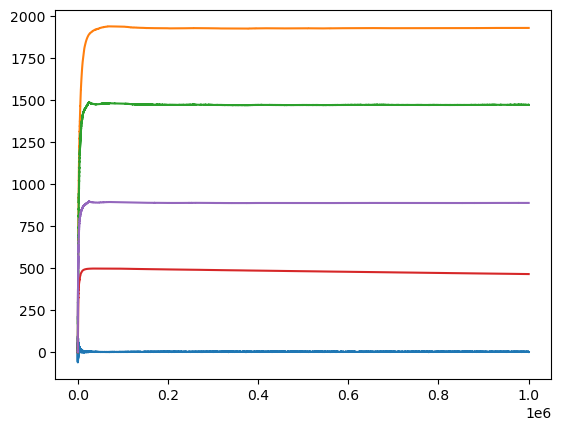

In [96]:
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [97]:
params = resultUnifApprox[1]
s = fill(1, N)
println(v(s, params, features))
for i in 1:N
    s[i] = 3
    println(v(s, params, features))
end

1.706543091320888
77.46871429849979
157.66839999285958
242.30560017440018
331.38031484312177
424.89254399902416
522.8422876421074
625.2295457723715
732.0543183898168
843.3166054944426
959.0164070862494
1079.153723165237
1203.7285537314053
1332.740898784755
1466.190758325285
1604.0781323529964
1746.4030208678887
1893.1654238699612
2044.365341359215
2200.0027733356496
2360.0777197992657


In [99]:
evalNMax = 1000000
gs = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, params, features; printProgress = true, modCounter = 100000)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


([0.0, 10.0, 10.0, 16.822212290937824, 14.973666792051501, 14.973666792051501, 15.219995766042903, 15.019847814634831, 15.019847814634831, 19.88786361115233  …  21.074499318099512, 21.074499318099512, 21.074504821746093, 21.074504821746093, 21.074613686674784, 21.074634981612594, 21.07462331121917, 21.07462331121917, 21.074660828463188, 21.074603708503652], [0.0, 164.86527768305734, 297.6459056152363, 363.4071861452418, 370.34554576251827, 380.0473653059502, 530.4077996870344, 555.3685247704859, 611.7872625692664, 918.8123660424309  …  6.2853626788205706e7, 6.285364666584335e7, 6.285371805044799e7, 6.285373557246494e7, 6.285375587689293e7, 6.285411678016843e7, 6.285419534306919e7, 6.285422677208225e7, 6.285436518376547e7, 6.285451901146568e7], [0.0, 16.486527768305734, 17.693624385870997, 24.269752438871546, 24.33282843539224, 25.303010389735437, 26.669923429563475, 29.165995937908622, 34.80786971778667, 37.599007022088166  …  2.9824501227541924e6, 2.9824521105179572e6, 2.9824527594689

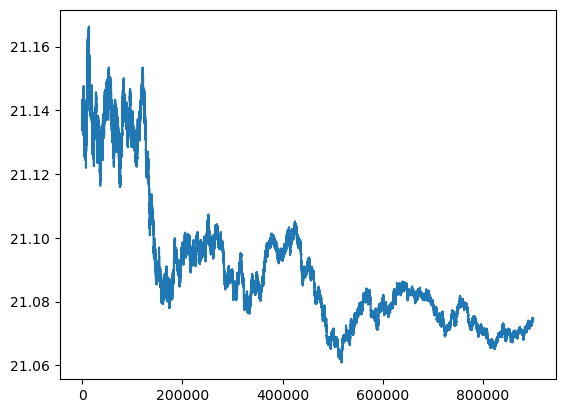

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000996F070>

In [101]:
PyPlot.plot(gs[1][100000:evalNMax])

In [116]:
evalResultCont = rpiHomogVFAApprox(N, resultUnifApprox[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001, 21.487; nMax = 0, delScale = 1, forceActive = true)

(21.48708293526832, [0.0 99.90009976607418 … 1898.3781389874853 2047.3022182529517; 95.72569112723599 195.62578976591703 … 2045.7355903839305 0.0; … ; 1885.708123922872 2083.559395609166 … 0.0 0.0; 2083.559395609166 0.0 … 0.0 0.0], 3421, [0 0 … 0 0; 0 0 … 0 0; … ; 9 9 … 0 0; 10 0 … 0 0])

In [105]:
evalResultCont[4]

21×21 Matrix{Int64}:
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  1  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  2  2  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  3  2  2  1  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
  3  3  2  2  2  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  4  3  3  3  2  2  2  1  0  1  0  0  0  0  0  0  0  0  0  0  0
  4  4  4  3  3  3  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0
  5  5  4  4  4  3  3  3  0  0  0  0  0  0  0  0  0  0  0  0  0
  6  5  5  5  4  4  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  6  6  6  5  5  5 

In [109]:
nMax = 1000000
stepsize = 1/10
resultContOld = approxValueIterationContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


In [110]:
numPar = length(vParams)
paramHist = resultContOld[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

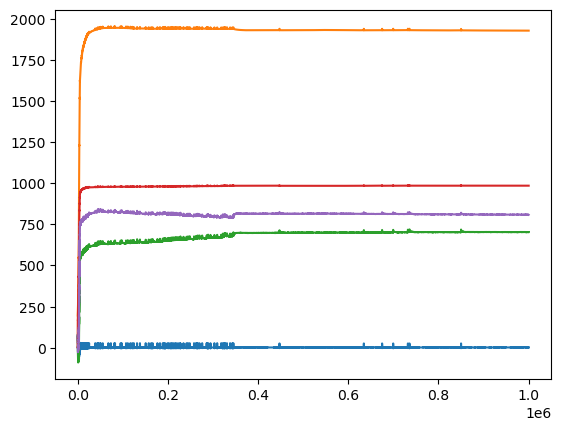

In [111]:
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [118]:
evalResultContOld = rpiHomogVFAApprox(N, resultContOld[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001, 20.40456; nMax = 0, delScale = 1, forceActive = true)

(20.404561643950032, [0.0 99.90009990009983 … 1898.3783977211258 2047.347584854295; 86.70468036625027 186.60478026635 … 2036.7627710281647 0.0; … ; 1800.1225606321707 2389.9201796072184 … 0.0 0.0; 2389.9201796072184 0.0 … 0.0 0.0], 6826, [0 0 … 0 0; 0 0 … 0 0; … ; 2 1 … 0 0; 2 0 … 0 0])

Woah!

In [119]:
evalResultContOld[4]

21×21 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  

# Inhomogeneous problem

## New update

In [153]:
N=5
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:5] 
c1=100.0
r=[100.0*i for i in 1:5] 
repIndicators = [s -> (s[i]==2)*(s[j]==2) for i in 1:N for j in i:N]
damIndicators = [s -> (s[i]==3)*(s[j]==3) for i in 1:N for j in i:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
nMax = 500000
stepsize = 1/500
resultContNew = approxValueIterationContNew(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
Complete


Table Complete


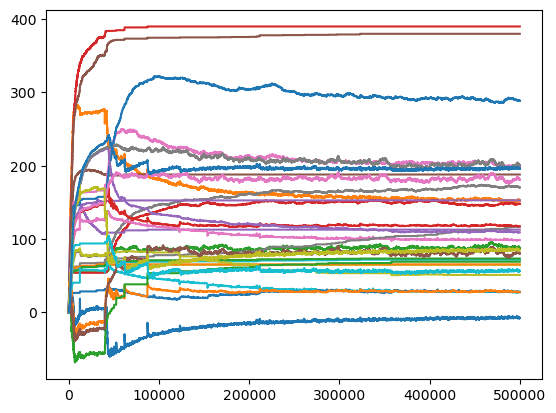

In [154]:
numPar = length(vParams)
paramHist = resultContNew[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [181]:
evalResultContNew = rpiVFAInstant(N, resultContNew[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, 32.696; nMax = 10000, delScale = N, printProgress = true, modCounter = 1000)

1000
2000


(32.7222998789982, Dict{Any, Any}([2, 1, 3, 1, 1] => 419.23579083629284, [2, 3, 1, 2, 3] => 1057.716897413197, [2, 1, 2, 2, 2] => 1330.081698197301, [3, 2, 1, 3, 3] => 361.8128474479919, [3, 2, 2, 2, 1] => 1274.527652812875, [3, 2, 2, 1, 3] => 1085.6673098302035, [1, 2, 3, 2, 3] => 1426.7934414178712, [1, 2, 1, 1, 2] => 705.3801039161724, [1, 2, 2, 3, 1] => 595.8106902885216, [3, 1, 3, 3, 3] => 374.33014334830466…), 2746)

In [182]:
evalResultContNewExact = rpiVFA(N, resultContNew[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 10000, delScale = N, printProgress = true, modCounter = 1000)

1000
2000


(32.7119296195083, Dict{Any, Any}([2, 1, 3, 1, 1] => 415.3925057569504, [2, 3, 1, 2, 3] => 1040.4738289927552, [2, 1, 2, 2, 2] => 1329.8888774228665, [3, 2, 1, 3, 3] => 360.69968839112056, [3, 2, 2, 2, 1] => 1269.1300193457648, [3, 2, 2, 1, 3] => 1069.1897597638003, [1, 2, 3, 2, 3] => 1399.1090982415544, [1, 2, 1, 1, 2] => 705.2626566026402, [1, 2, 2, 3, 1] => 595.6489547165693, [3, 1, 3, 3, 3] => 373.2169842914332…), 2757)

In [160]:
evalNMax = 100000
gsNew = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContNew[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsNew[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


100001-element Vector{Float64}:
  0.0
 10.0
 10.0
 25.236376973379663
 20.831477853894132
 20.831477853894132
 21.05556680344795
 31.44170247699941
 25.906904646822728
 25.906904646822728
 29.064258754450282
 31.042458331150268
 22.841167082649697
  ⋮
 26.505815347469717
 26.5058309092038
 26.50565695382776
 26.50565695382776
 26.505840695658392
 26.50557957004505
 26.50557957004505
 26.505835474521156
 26.505791466178245
 26.505791466178245
 26.5058402052783
 26.5058402052783

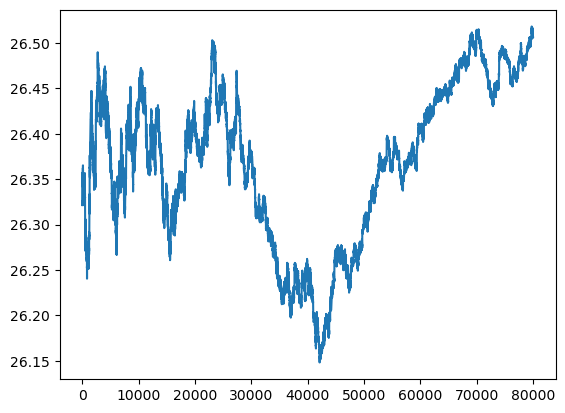

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007CA82550>

In [161]:
PyPlot.plot(gsNew[1][20000:evalNMax])

Discrepancy between simulation and exact. Try fixed version of simulation. 

In [171]:
evalNMax = 100000
gsNewFix = gEvaluationContFixed(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContNew[1], features, 32.678; printProgress = true, modCounter = 10000, forceActive = true)
gsNewFix[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


100001-element Vector{Float64}:
  0.0
 10.0
 10.0
 45.588277186944985
 29.296158730144366
 29.296158730144366
 34.06231599324392
 40.83656276678898
 37.28465125631562
 37.28465125631562
 37.63796589622859
 36.05613747262614
 36.05613747262614
  ⋮
 26.85464958709915
 26.854690900483963
 26.853365047339775
 26.853365047339775
 26.854332297806376
 26.854332297806376
 26.85438387106339
 26.854779702600528
 26.85465288724935
 26.85465288724935
 26.855343678959724
 26.85503922594187

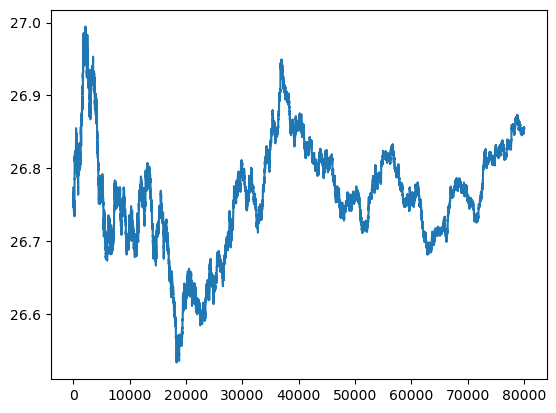

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007C9C0AC0>

In [172]:
PyPlot.plot(gsNewFix[1][20000:evalNMax])

Discrepancy still present, try contFromS?

In [177]:
evalNMax = 100000
s = fill(3,N)
gsNewFix2 = gEvaluationContFromSFixed(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContNew[1], features, 32.678; printProgress = true, modCounter = 10000, forceActive = true)
gsNewFix2[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


100001-element Vector{Float64}:
    0.0
    0.0
    0.0
    0.0
 1600.0
 1469.1917864264153
  566.6651177859553
   64.53965152059544
   64.53965152059544
   66.54890735863486
   66.54890735863486
   78.23842997057804
   78.45263196945638
    ⋮
   26.32111270735743
   26.320848145834493
   26.320848145834493
   26.3212827521612
   26.321185441545076
   26.321185441545076
   26.32129171973282
   26.321231818122502
   26.321231818122502
   26.321702974961067
   26.321702974961067
   26.321909433762247

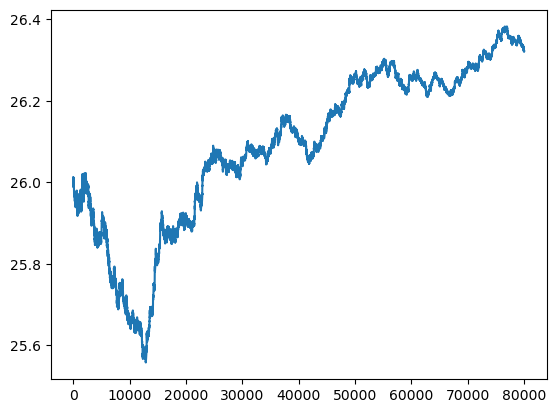

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007CA2E3A0>

In [180]:
PyPlot.plot(gsNewFix2[1][20000:evalNMax])

Same thing

## Old

In [162]:
nMax = 500000
stepsize = 1/500
resultContOld = approxValueIterationContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
Complete


Table Complete


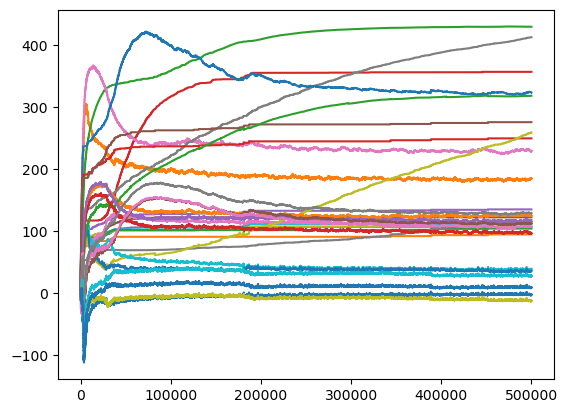

In [163]:
numPar = length(vParams)
paramHist = resultContOld[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [183]:
evalResultContOld = rpiVFAInstant(N, resultContOld[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, 28.831; nMax = 10000, delScale = N, printProgress = true, modCounter = 1000)

1000
2000
3000


(29.303671016000052, Dict{Any, Any}([2, 1, 3, 1, 1] => -158.39858995917695, [2, 3, 1, 2, 3] => 1333.3360322995002, [2, 1, 2, 2, 2] => 1331.9023002130957, [3, 2, 1, 3, 3] => 501.7278808845529, [3, 2, 2, 2, 1] => 1277.0177183298872, [3, 2, 2, 1, 3] => 1403.400682410097, [1, 2, 3, 2, 3] => 526.7353437813363, [1, 2, 1, 1, 2] => 698.6430106876226, [1, 2, 2, 3, 1] => 1291.9689020356896, [3, 1, 3, 3, 3] => 496.2836351365928…), 3849)

In [184]:
evalResultContOldExact = rpiVFA(N, resultContOld[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 10000, delScale = N, printProgress = true, modCounter = 1000)

1000
2000
3000


(29.303671016000052, Dict{Any, Any}([2, 1, 3, 1, 1] => -158.39858995917695, [2, 3, 1, 2, 3] => 1333.3360322995002, [2, 1, 2, 2, 2] => 1331.864791560277, [3, 2, 1, 3, 3] => 501.7278808845529, [3, 2, 2, 2, 1] => 1277.0177183298872, [3, 2, 2, 1, 3] => 1403.400682410097, [1, 2, 3, 2, 3] => 526.7353437813363, [1, 2, 1, 1, 2] => 698.6430106876226, [1, 2, 2, 3, 1] => 1291.9689020356896, [3, 1, 3, 3, 3] => 496.2836351365928…), 3849)

In [192]:
evalResultContOldExact[2]

Dict{Any, Any} with 243 entries:
  [2, 1, 3, 1, 1] => -158.399
  [2, 3, 1, 2, 3] => 1333.34
  [2, 1, 2, 2, 2] => 1331.86
  [3, 2, 1, 3, 3] => 501.728
  [3, 2, 2, 2, 1] => 1277.02
  [3, 2, 2, 1, 3] => 1403.4
  [1, 2, 3, 2, 3] => 526.735
  [1, 2, 1, 1, 2] => 698.643
  [1, 2, 2, 3, 1] => 1291.97
  [3, 1, 3, 3, 3] => 496.284
  [3, 3, 1, 1, 1] => 142.105
  [3, 3, 3, 3, 2] => 2515.92
  [1, 1, 3, 1, 2] => 180.247
  [2, 2, 3, 2, 2] => 1228.8
  [2, 3, 3, 3, 1] => 542.936
  [3, 2, 1, 2, 3] => 1501.99
  [1, 2, 1, 3, 3] => 10.9105
  [1, 2, 2, 2, 1] => 911.591
  [1, 2, 2, 1, 3] => 1224.57
  [3, 1, 3, 2, 3] => 482.062
  [3, 1, 1, 1, 2] => 661.101
  [3, 3, 3, 2, 2] => 2105.12
  [3, 1, 2, 3, 1] => 1387.15
  [1, 1, 3, 3, 3] => 100.747
  [1, 3, 1, 1, 1] => 26.7711
  ⋮               => ⋮

In [197]:
stateSpace = enumerateStates(N)
lowest = 0.0
lowestState = [1,1,1,1,1]
table = evalResultContOldExact[2]
for s in stateSpace
    if table[s] <= lowest
        lowest = table[s]
        lowestState = s
    end
end

lowest, lowestState

(-317.8284257546951, [1, 1, 3, 1, 1])

Maybe policy is stupid when 3 is healthy?

In [166]:
evalNMax = 100000
gsOld = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContOld[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsOld[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


100001-element Vector{Float64}:
  0.0
 10.0
 10.0
 18.967910148729793
 15.752886872694686
 15.752886872694686
 17.887815878266192
 13.27098778620831
 13.27098778620831
 13.684948358099046
 13.00771015749216
 13.00771015749216
 14.62521321517407
  ⋮
 28.268949879723348
 28.270412115214505
 28.270401822377266
 28.270401822377266
 28.270508726064143
 28.268701936160433
 28.268701936160433
 28.268892693984792
 28.26760075625499
 28.26760075625499
 28.267601916001794
 28.267833472155218

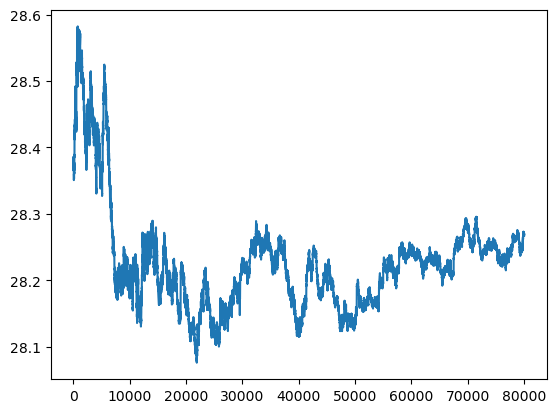

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007CA42940>

In [167]:
PyPlot.plot(gsOld[1][20000:evalNMax])

In [185]:
resultOpt = rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 10000, delScale = N, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(26.308462359220368, Dict{Any, Any}([2, 1, 3, 1, 1] => 371.89789227059373, [2, 3, 1, 2, 3] => 892.2548054548093, [2, 1, 2, 2, 2] => 1345.995225387021, [3, 2, 1, 3, 3] => 694.1069562316807, [3, 2, 2, 2, 1] => 1088.1611943632765, [3, 2, 2, 1, 3] => 807.4164403082596, [1, 2, 3, 2, 3] => 994.7834056401967, [1, 2, 1, 1, 2] => 699.2038744232025, [1, 2, 2, 3, 1] => 647.7244866342568, [3, 1, 3, 3, 3] => 752.7546028956649…), 10000, Dict{Any, Any}([2, 1, 3, 1, 1] => [0, 0, 0, 0, 0], [2, 3, 1, 2, 3] => [0, 0, 0, 0, 0], [2, 1, 2, 2, 2] => [0, 0, 0, 0, 0], [3, 2, 1, 3, 3] => [0, 0, 0, 0, 0], [3, 2, 2, 2, 1] => [0, 0, 0, 0, 0], [3, 2, 2, 1, 3] => [0, 0, 0, 0, 0], [1, 2, 3, 2, 3] => [0, 0, 0, 0, 0], [1, 2, 1, 1, 2] => [0, 0, 0, 0, 0], [1, 2, 2, 3, 1] => [0, 0, 0, 0, 0], [3, 1, 3, 3, 3] => [0, 0, 0, 0, 0]…))

In [150]:
resultOpt[2][[3,3,3,3,3]]

1397.7609163455922

In [191]:
resultOpt[2][[2,2,2,2,3]]

1409.2321093590556

## Attempt to force negative value function

In [69]:
N=5
function tau(n)
    return n
end
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:5] 
c1=100.0
r=[100.0*i for i in 1:5] 

policy = Dict()
stateSpace = enumerateStates(N)
for s in stateSpace
    if s[3] != 3
        policy[s] = zeros(Int64,N)
    else
        a = zeros(Int64, N)
        if s[1] == 3
            a[1] = 1
        end
        if s[2] == 3
            a[2] = 1
        end
        if s[1] == 1 && s[2] == 1 && s[4] == 3
            a[4] = 1
        end
        policy[s] = a
    end
end

In [70]:
result = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(28.344662006289436, Dict{Any, Any}([2, 1, 3, 1, 1] => -109.49297463842332, [2, 3, 1, 2, 3] => 861.7668457699676, [2, 1, 2, 2, 2] => 1323.291040488249, [3, 2, 1, 3, 3] => 1351.2241370300594, [3, 2, 2, 2, 1] => 1207.9906486796463, [3, 2, 2, 1, 3] => 1183.2804897193994, [1, 2, 3, 2, 3] => 583.8260261300265, [1, 2, 1, 1, 2] => 693.780537848056, [1, 2, 2, 3, 1] => 968.3014492984477, [3, 1, 3, 3, 3] => 583.9924031794238…), 10000)

In [72]:
result[2][[1,1,3,1,1]]

-260.27337717184946

Aight fine, negative value functions can happen

# Testing APE-FA-Cont algorithms with new update rules on N = 20 problem

Following the change to AVI-Cont, we use update targets c + V* - gt - V(s0) where V* is V(s') or E{V(s')}

## Approx

In [111]:
Random.seed!(12345)
function tau(n)
    return n
end

#define features
function numRep(s)
    n = length(s)
    return sum(s[i] == 2 for i in 1:n)/n
end

function numDamage(s)
    n = length(s)
    return sum(s[i] == 3 for i in 1:n)/n
end

function numRepSq(s)
    return numRep(s)^2
end

function numDamageSq(s)
    return numDamage(s)^2
end

N=20
alpha_d = [0.01 for i in 1:N]
alpha_r = [0.001 for i in 1:N] 
beta=10.0
c0=[1.0 for i in 1:N] 
c1=100.0
r=[100.0 for i in 1:N]
nMax = 2000000
stepsize = 1/100
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultContApprox = apeFAContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
Complete


Table Complete


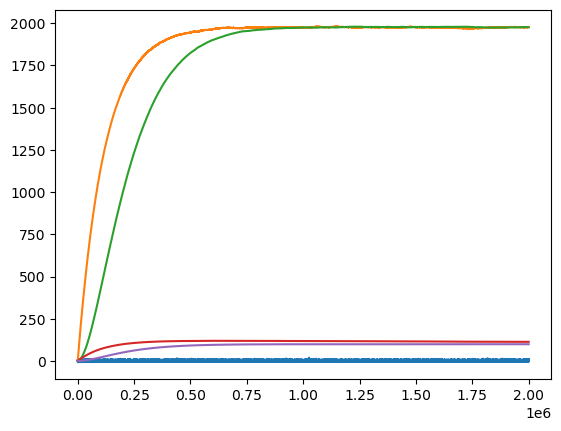

In [112]:
numPar = length(vParams)
paramHist = resultContApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

AYO

## Full

In [109]:
nMax = 200000
stepsize = 1/10
resultContFull = apeFAContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 10000)
println("Complete")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
Complete


Table Complete


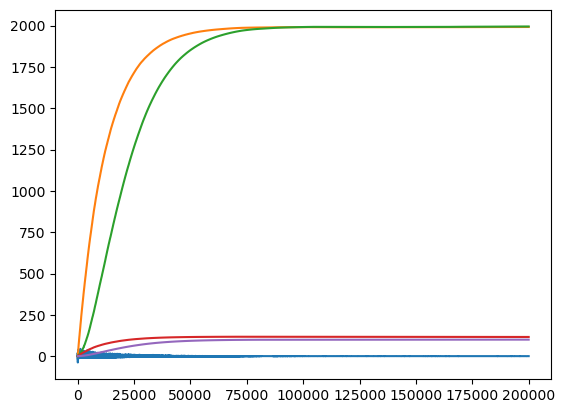

In [110]:
numPar = length(vParams)
paramHist = resultContFull[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

Neat.

## ApproxST (state trace)

In [113]:
nMax = 2000000
stepsize = 1/100
resultContAppoxST = apeFAContApproxST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
Complete


Table Complete


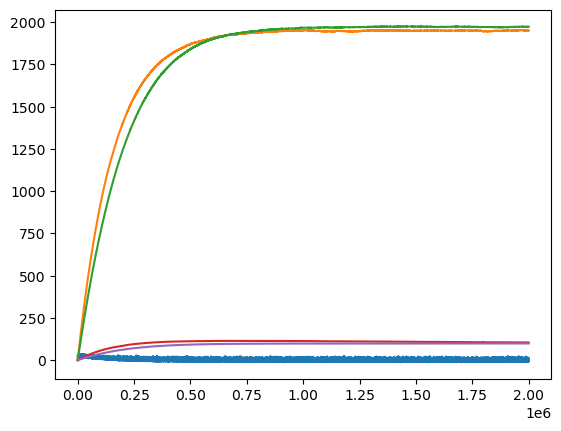

In [114]:
numPar = length(vParams)
paramHist = resultContAppoxST[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

## FullST

In [115]:
nMax = 200000
stepsize = 1/10
resultContFullST = apeFAContFullST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 10000)
println("Complete")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
Complete


Table Complete


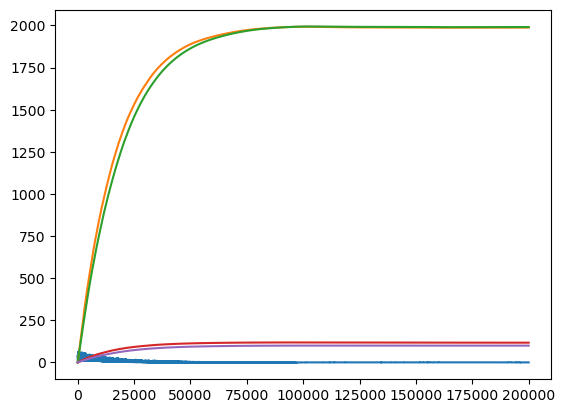

In [116]:
numPar = length(vParams)
paramHist = resultContFullST[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

These all seem to learn far faster than the Unif equivalents.

# Testing APE-FA-Cont algorithms with new update rules on N = 5 inhomogeneous problem

In [119]:
#Example 2 from Masters inhomog section
function tau(n)
    return n
end

N=5
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:5] 
c1=100.0
r=[100.0*i for i in 1:5] 
repIndicators = [s -> (s[i]==2)*(s[j]==2) for i in 1:N for j in i:N]
damIndicators = [s -> (s[i]==3)*(s[j]==3) for i in 1:N for j in i:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
nMax = 1000000
stepsize = 1/500
resultContApprox = apeFAContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


Table Complete


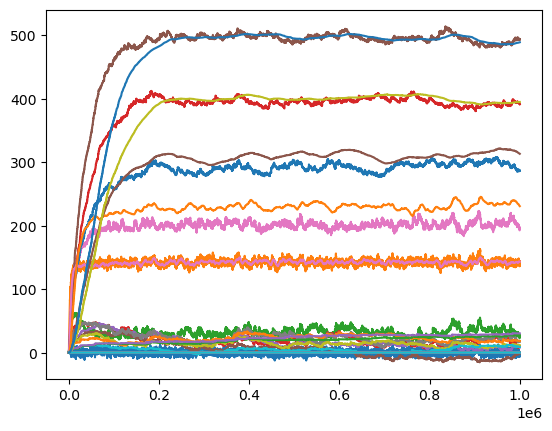

In [120]:
numPar = length(vParams)
paramHist = resultContApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [123]:
nMax = 100000
stepsize = 1/50
resultContFull = apeFAContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 10000)
println("Complete")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
Complete


Table Complete


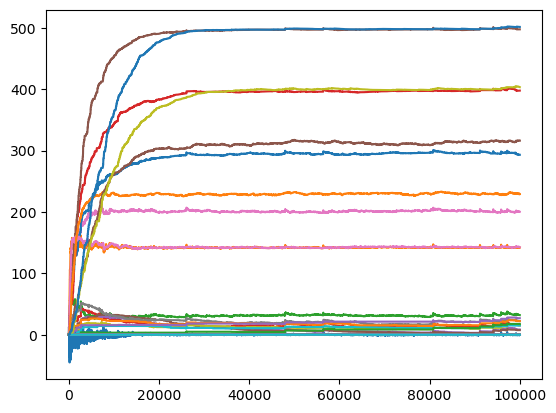

In [124]:
numPar = length(vParams)
paramHist = resultContFull[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

Nice!

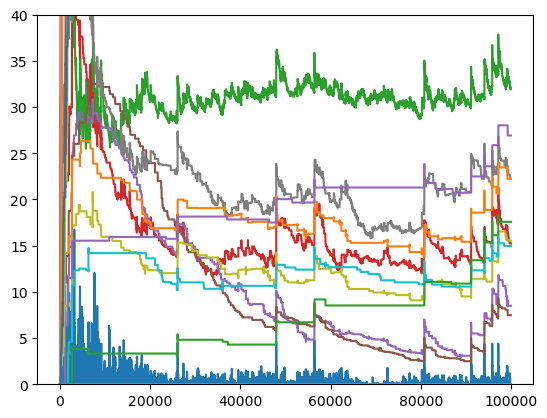

In [126]:
ylim(0,40)
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

Closer inspection doesn't necessarily show convergence, but overall parameters are more stable than the Approx version.

In [128]:
nMax = 1000000
stepsize = 1/500
resultContApproxST = apeFAContApproxST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


Table Complete


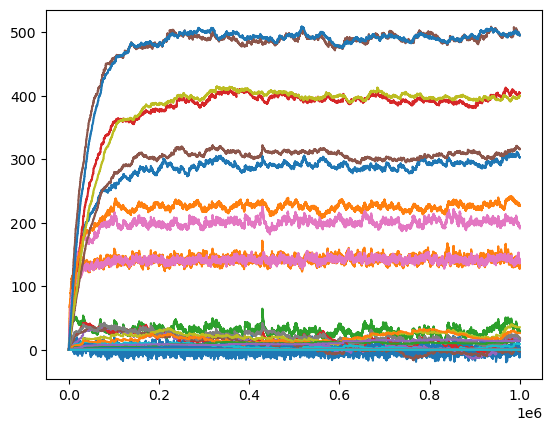

In [129]:
numPar = length(vParams)
paramHist = resultContApproxST[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

Similar but perhaps more erratic than Approx

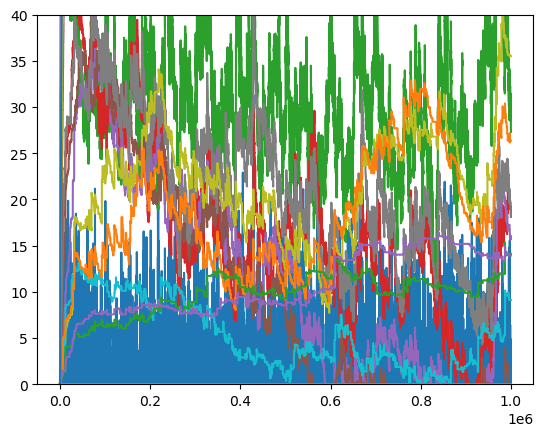

In [131]:
ylim(0,40)
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

Far less stable than Full!

In [130]:
nMax = 100000
stepsize = 1/50
resultContFullST = apeFAContFullST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 10000)
println("Complete")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
Complete


Table Complete


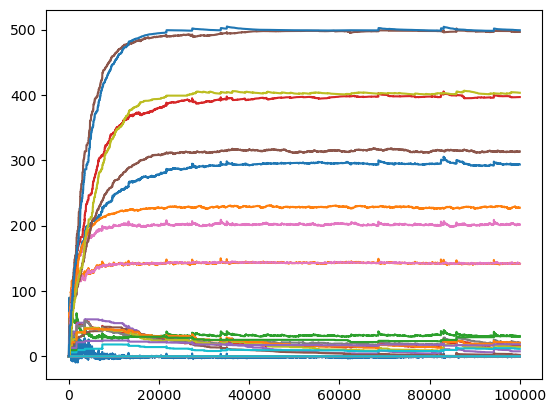

In [132]:
numPar = length(vParams)
paramHist = resultContFullST[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end
println("Table Complete")
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

Again not much difference to doing it without ST.

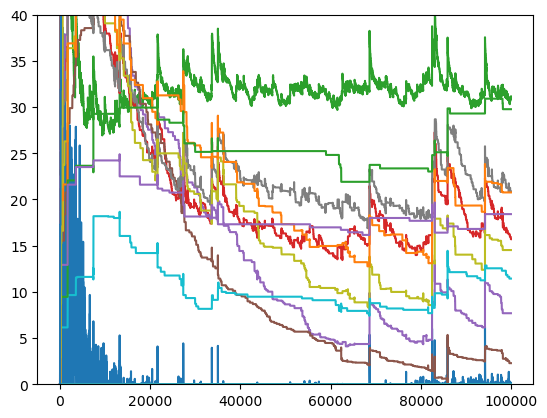

In [133]:
ylim(0,40)
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

## Compare FA and FA-PI through simulation, using resultContFull

In [144]:
evalNMax = 2000000
gsFA = gEvaluationContFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax; printProgress = true, modCounter = 100000)
gsFA[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000


2000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 13.039370977621278
 10.912152981472321
 10.912152981472321
 37.594195287490145
 26.044443864779744
 26.044443864779744
 26.809759692709214
 23.476032657805266
 23.476032657805266
 23.940101354825376
  ⋮
 29.780233111957408
 29.78023376517638
 29.78019892136659
 29.78019892136659
 29.78020522838543
 29.780174654003908
 29.780174654003908
 29.78018690374186
 29.780177132975524
 29.780177132975524
 29.78018559480784
 29.780166425982017

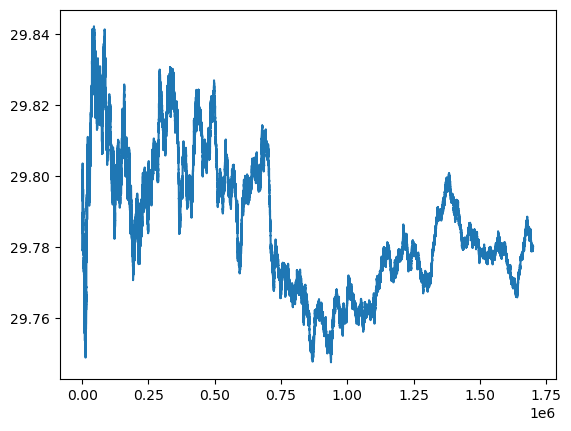

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A84DF2E0>

In [149]:
PyPlot.plot(gsFA[1][300000:evalNMax])

In [146]:
gsPI = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContFull[1], features; printProgress = true, modCounter = 100000)
gsPI[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000


2000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 14.598464060303465
 13.937737948150794
 13.937737948150794
 18.04691693487882
 12.506590691968281
 12.506590691968281
 14.2060704705156
 12.990438009756147
 12.990438009756147
 13.454938566011279
  ⋮
 29.5348935121583
 29.534904502386887
 29.53489266182032
 29.53489266182032
 29.534917213067608
 29.53478460136587
 29.53478460136587
 29.534792723324877
 29.5347695451464
 29.5347695451464
 29.53479201403912
 29.53474190730365

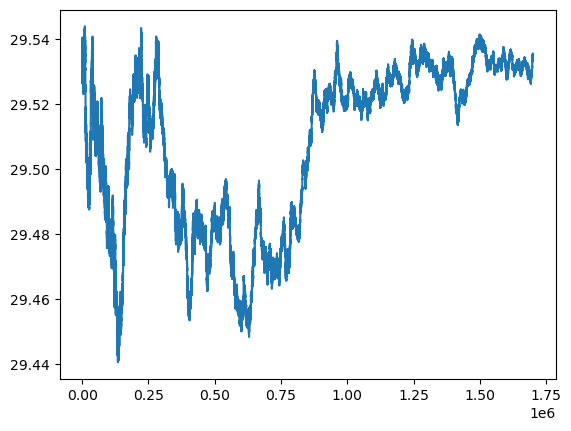

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000008915D3A0>

In [150]:
PyPlot.plot(gsPI[1][300000:evalNMax])

Improved from 29.76 - 29.84 to 29.44 to 29.54. Encouraging! 